In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
# from statsmodels.regression.quantile_regression import QuantReg

In [2]:
import pickle
policy_model = "Qwen2.5-1.5B-Instruct"
reward_model = "QRM-Llama3.1-8B-v2"
window = 100 # training steps
prompt = 16 # batch size per window
gen = 16 # number of outputs per prompt
seed = 42   

filename = f"{policy_model}_{reward_model}_window{window}_prompt{prompt}_gen{gen}_seed{seed}.pkl"

with open(filename, "rb") as f:
    reward_outputs = pickle.load(f)

In [6]:
# decode input ids to text

from transformers import AutoTokenizer
full_reward_path = "nicolinho/QRM-Llama3.1-8B-v2"
tokenizer = AutoTokenizer.from_pretrained(full_reward_path, use_fast=True)

In [10]:
# shape: n_prompts, n_outputs, seq_len
reward_outputs[0]['input_ids'].shape

(16, 16, 1188)

In [12]:
# generations of the first prompt
first_prompt_generations = reward_outputs[0]['input_ids'][0]
first_prompt_generations.shape

(16, 1188)

In [16]:
decoded_generations = tokenizer.batch_decode(first_prompt_generations)
print(decoded_generations[1])

<|begin_of_text|><|start_header_id|>system<|end_header_id|>

Cutting Knowledge Date: December 2023
Today Date: 26 Jul 2024

You are a helpful AI Assistant that provides well-reasoned and detailed responses. You first think about the reasoning process as an internal monologue and then provide the user with the answer. Respond in the following format: <think>
...
</think>
<answer>
...
</answer><|eot_id|><|start_header_id|>user<|end_header_id|>

Write a research report of at least 8 pages (double-spaced, 12-point font) exploring the relationship between listening to music and memory retention, recall, and cognitive function in both adults and children. Include a detailed literature review of at least 10 scholarly articles or studies and analyze their methods and findings. Discuss the potential implications of your findings for future research or practical applications, such as using music therapy to improve memory or cognitive function in elderly individuals. Use APA style for in-text cit

In [3]:
print(f"Type of loaded object: {type(reward_outputs)}")
# print(f"Length: {len(reward_outputs)}")
# print(f"First few items types: {[type(item) for item in reward_outputs[:3]]}")
# print(f"Preview: {reward_outputs[:1]}")

Type of loaded object: <class 'list'>


In [29]:
# step: training step
# input_ids: input ids of the prompt + completion, shape: (prompt, seq_len)
# reward_quantiles: quantiles of the reward, shape: (prompt, 20)
# reward_detailed: detailed reward ['helpsteer-helpfulness','helpsteer-correctness','helpsteer-coherence', 'helpsteer-complexity','helpsteer-verbosity'], shape: (prompt, 5)
# reward_aggregated: aggregated reward, shape: (prompt,)
reward_outputs[0].keys()

dict_keys(['step', 'input_ids', 'reward_quantiles', 'reward_detailed', 'reward_aggregated', 'hidden_states'])

In [114]:
# Set up for (hidden state of output, reward) regression

# data points up to (window - 1)th steps
for w in range(window-1):
    if w == 0:
        reward_q05 = reward_outputs[w]['reward_quantiles'][:, :, 0].flatten() # (prompt, gen)
        reward_q25 = reward_outputs[w]['reward_quantiles'][:, :, 4].flatten() # (prompt, gen)
        reward_median = reward_outputs[w]['reward_quantiles'][:, :, 9].flatten() # (prompt, gen)
        reward_q75 = reward_outputs[w]['reward_quantiles'][:, :, 14].flatten() # (prompt, gen)
        reward_q95 = reward_outputs[w]['reward_quantiles'][:, :, 18].flatten() # (prompt, gen)
        hidden_states = reward_outputs[w]['hidden_states'].reshape(-1, *reward_outputs[w]['hidden_states'].shape[2:])
    elif w > 0:
        reward_q05_w = reward_outputs[w]['reward_quantiles'][:, :, 0].flatten() # (prompt, gen)
        reward_q25_w = reward_outputs[w]['reward_quantiles'][:, :, 4].flatten() # (prompt, gen)
        reward_median_w = reward_outputs[w]['reward_quantiles'][:, :, 9].flatten() # (prompt, gen)
        reward_q75_w = reward_outputs[w]['reward_quantiles'][:, :, 14].flatten() # (prompt, gen)
        reward_q95_w = reward_outputs[w]['reward_quantiles'][:, :, 18].flatten() # (prompt, gen)
        reward_q05 = np.concatenate((reward_q05, reward_q05_w))
        reward_q25 = np.concatenate((reward_q25, reward_q25_w))
        reward_median = np.concatenate((reward_median, reward_median_w))
        reward_q75 = np.concatenate((reward_q75, reward_q75_w))
        reward_q95 = np.concatenate((reward_q95, reward_q95_w))
        hidden_states_w = reward_outputs[w]['hidden_states'].reshape(-1, *reward_outputs[w]['hidden_states'].shape[2:])
        hidden_states = np.vstack((hidden_states, hidden_states_w))

reward_q05_train = np.array(reward_q05)
reward_q25_train = np.array(reward_q25)
reward_median_train = np.array(reward_median)
reward_q75_train = np.array(reward_q75)
reward_q95_train = np.array(reward_q95)
hidden_states_train = np.array(hidden_states)

reward_q05_test = reward_outputs[window-1]['reward_quantiles'][:, :, 0].flatten() # (prompt, gen)
reward_q25_test = reward_outputs[window-1]['reward_quantiles'][:, :, 4].flatten() # (prompt, gen)
reward_median_test = reward_outputs[window-1]['reward_quantiles'][:, :, 9].flatten() # (prompt, gen)
reward_q75_test = reward_outputs[window-1]['reward_quantiles'][:, :, 14].flatten() # (prompt, gen)
reward_q95_test = reward_outputs[window-1]['reward_quantiles'][:, :, 18].flatten() # (prompt, gen)
hidden_states_test = reward_outputs[window-1]['hidden_states'].reshape(-1, *reward_outputs[window-1]['hidden_states'].shape[2:])

In [116]:
# sanity check 
print(reward_median_train.shape)
print(reward_q05_train.shape)
print(hidden_states_train.shape)
print(reward_median_test.shape)
print(reward_q05_test.shape)
print(hidden_states_test.shape)

(25344,)
(25344,)
(25344, 4096)
(256,)
(256,)
(256, 4096)


In [117]:
# regression 

model_med = LinearRegression()
model_med.fit(hidden_states_train, reward_median_train)

model_q05 = LinearRegression()
model_q05.fit(hidden_states_train, reward_q05_train)

model_q25 = LinearRegression()
model_q25.fit(hidden_states_train, reward_q25_train)

model_q75 = LinearRegression()
model_q75.fit(hidden_states_train, reward_q75_train)

model_q95 = LinearRegression()
model_q95.fit(hidden_states_train, reward_q95_train)


# Make predictions on the test set
reward_median_pred = model_med.predict(hidden_states_test)
reward_q05_pred = model_q05.predict(hidden_states_test)
reward_q25_pred = model_q25.predict(hidden_states_test)
reward_q75_pred = model_q75.predict(hidden_states_test)
reward_q95_pred = model_q95.predict(hidden_states_test)


In [135]:

# Calculate metrics
mse_median = mean_squared_error(reward_median_test, reward_median_pred)
mse_q05 = mean_squared_error(reward_q05_test, reward_q05_pred)
mse_q25 = mean_squared_error(reward_q25_test, reward_q25_pred)
mse_q75 = mean_squared_error(reward_q75_test, reward_q75_pred)
mse_q95 = mean_squared_error(reward_q95_test, reward_q95_pred)

r2_median = r2_score(reward_median_test, reward_median_pred)
r2_q05 = r2_score(reward_q05_test, reward_q05_pred)
r2_q25 = r2_score(reward_q25_test, reward_q25_pred)
r2_q75 = r2_score(reward_q75_test, reward_q75_pred)
r2_q95 = r2_score(reward_q95_test, reward_q95_pred)


print(f"MSE: {mse_median}, {mse_q05}, {mse_q25}, {mse_q75}, {mse_q95}")
print(f"R2: {r2_median}, {r2_q05}, {r2_q25}, {r2_q75}, {r2_q95}")

MSE: 3.1275456422008574e-05, 3.885403566528112e-05, 3.838569682557136e-05, 7.770992851874325e-06, 5.402357601269614e-07
R2: 0.9320099949836731, 0.9504774808883667, 0.952215313911438, 0.9591633677482605, 0.8454058170318604


In [ ]:
# Distribution of predicted and observed median reward
plt.figure(figsize=(10, 6))
plt.hist(reward_median_pred, bins=30, alpha=0.5, color='blue', label='predicted')
plt.hist(reward_median_test, bins=30, alpha=0.5, color='green', label='observed')
plt.title('Compare predicted and observed median reward')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Matched plots per output for median reward

plt.figure(figsize=(10, 6))
plt.plot(range(len(reward_median_pred)), reward_median_pred, 'b-o', linewidth=1, markersize=4, label='predicted')
plt.plot(range(len(reward_median_test)), reward_median_test, 'r-o', linewidth=1, markersize=4, label='observed')
plt.title('Compare predicted and observed median reward')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True, alpha=0.1)
plt.legend()
plt.savefig('paired_1d_line_median.png')
plt.show()

In [ ]:
# Matched plots per output for q05 reward

plt.figure(figsize=(10, 6))
plt.plot(range(len(reward_q05_pred)), reward_q05_pred, 'b-o', linewidth=1, markersize=4, label='predicted')
plt.plot(range(len(reward_q05_test)), reward_q05_test, 'r-o', linewidth=1, markersize=4, label='observed')
plt.title('Compare predicted and observed q05 reward')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True, alpha=0.1)
plt.legend()
plt.savefig('paired_1d_line_q05.png')
plt.show()

In [ ]:
# Matched plots per output for q95 reward

plt.figure(figsize=(10, 6))
plt.plot(range(len(reward_q95_pred)), reward_q95_pred, 'b-o', linewidth=1, markersize=4, label='predicted')
plt.plot(range(len(reward_q95_test)), reward_q95_test, 'r-o', linewidth=1, markersize=4, label='observed')
plt.title('Compare predicted and observed q95 reward')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True, alpha=0.1)
plt.legend()
plt.savefig('paired_1d_line_q95.png')
plt.show()

In [ ]:
# Matched plots per output for q75 reward

plt.figure(figsize=(10, 6))
plt.plot(range(len(reward_q75_pred)), reward_q75_pred, 'b-o', linewidth=1, markersize=4, label='predicted')
plt.plot(range(len(reward_q75_test)), reward_q75_test, 'r-o', linewidth=1, markersize=4, label='observed')
plt.title('Compare predicted and observed q75 reward')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True, alpha=0.1)
plt.legend()
plt.savefig('paired_1d_line_q75.png')
plt.show()

In [ ]:
# Matched plots per output for q25 reward

plt.figure(figsize=(10, 6))
plt.plot(range(len(reward_q25_pred)), reward_q25_pred, 'b-o', linewidth=1, markersize=4, label='predicted')
plt.plot(range(len(reward_q25_test)), reward_q25_test, 'r-o', linewidth=1, markersize=4, label='observed')
plt.title('Compare predicted and observed q25 reward')
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True, alpha=0.1)
plt.legend()
plt.savefig('paired_1d_line_q25.png')
plt.show()

In [ ]:
# Matched plots per output for median reward, per prompt

reward_median_pred_perprompt = reward_median_pred.reshape(16, 16)
reward_median_test_perprompt = reward_median_test.reshape(16, 16)


fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

for i in range(16):
    ax = axes[i]
    ax.plot(range(len(reward_median_pred_perprompt[i])), reward_median_pred_perprompt[i], 'b-o', linewidth=1, markersize=4, label='predicted')
    ax.plot(range(len(reward_median_test_perprompt[i])), reward_median_test_perprompt[i], 'r-o', linewidth=1, markersize=4, label='observed')

    
    # Set title and grid
    ax.grid(True, alpha=0.3)
    
# Adjust layout
plt.tight_layout()

# Show the plot
plt.savefig("math_functions_grid.png", dpi=150)
plt.show()

In [143]:
# How long can a trained reward model forecast into the future?
# train up to 80th steps and use it to forecast the next 20 steps
reduced_windows = 70

for w in range(reduced_windows):
    if w == 0:
        reward_q05 = reward_outputs[w]['reward_quantiles'][:, :, 0].flatten() # (prompt, gen)
        reward_q25 = reward_outputs[w]['reward_quantiles'][:, :, 4].flatten() # (prompt, gen)
        reward_median = reward_outputs[w]['reward_quantiles'][:, :, 9].flatten() # (prompt, gen)
        reward_q75 = reward_outputs[w]['reward_quantiles'][:, :, 14].flatten() # (prompt, gen)
        reward_q95 = reward_outputs[w]['reward_quantiles'][:, :, 18].flatten() # (prompt, gen)
        hidden_states = reward_outputs[w]['hidden_states'].reshape(-1, *reward_outputs[w]['hidden_states'].shape[2:])
    elif w > 0:
        reward_q05_w = reward_outputs[w]['reward_quantiles'][:, :, 0].flatten() # (prompt, gen)
        reward_q25_w = reward_outputs[w]['reward_quantiles'][:, :, 4].flatten() # (prompt, gen)
        reward_median_w = reward_outputs[w]['reward_quantiles'][:, :, 9].flatten() # (prompt, gen)
        reward_q75_w = reward_outputs[w]['reward_quantiles'][:, :, 14].flatten() # (prompt, gen)
        reward_q95_w = reward_outputs[w]['reward_quantiles'][:, :, 18].flatten() # (prompt, gen)
        reward_q05 = np.concatenate((reward_q05, reward_q05_w))
        reward_q25 = np.concatenate((reward_q25, reward_q25_w))
        reward_median = np.concatenate((reward_median, reward_median_w))
        reward_q75 = np.concatenate((reward_q75, reward_q75_w))
        reward_q95 = np.concatenate((reward_q95, reward_q95_w))
        hidden_states_w = reward_outputs[w]['hidden_states'].reshape(-1, *reward_outputs[w]['hidden_states'].shape[2:])
        hidden_states = np.vstack((hidden_states, hidden_states_w))

reward_q05_train = np.array(reward_q05)
reward_q25_train = np.array(reward_q25)
reward_median_train = np.array(reward_median)
reward_q75_train = np.array(reward_q75)
reward_q95_train = np.array(reward_q95)
hidden_states_train = np.array(hidden_states)

In [144]:
# regression trained for first 70 training steps
model_med = LinearRegression()
model_med.fit(hidden_states_train, reward_median_train)

model_q05 = LinearRegression()
model_q05.fit(hidden_states_train, reward_q05_train)

model_q25 = LinearRegression()
model_q25.fit(hidden_states_train, reward_q25_train)

model_q75 = LinearRegression()
model_q75.fit(hidden_states_train, reward_q75_train)

model_q95 = LinearRegression()
model_q95.fit(hidden_states_train, reward_q95_train)

# save mse and r2 for each forecasting step
mse_median_lst = []
mse_q05_lst = []
mse_q25_lst = []
mse_q75_lst = []
mse_q95_lst = []
r2_median_lst = []
r2_q05_lst = []
r2_q25_lst = []
r2_q75_lst = []
r2_q95_lst = []

# forecast the next 20 steps using pretrained regression model
for i in range(30):
    reward_q05_test = reward_outputs[reduced_windows + i]['reward_quantiles'][:, :, 0].flatten() 
    reward_q25_test = reward_outputs[reduced_windows + i]['reward_quantiles'][:, :, 4].flatten() 
    reward_median_test = reward_outputs[reduced_windows + i]['reward_quantiles'][:, :, 9].flatten()
    reward_q75_test = reward_outputs[reduced_windows + i]['reward_quantiles'][:, :, 14].flatten() 
    reward_q95_test = reward_outputs[reduced_windows + i]['reward_quantiles'][:, :, 18].flatten()
    hidden_states_test = reward_outputs[reduced_windows + i]['hidden_states'].reshape(-1, *reward_outputs[reduced_windows + i]['hidden_states'].shape[2:])

    reward_median_pred = model_med.predict(hidden_states_test)
    reward_q05_pred = model_q05.predict(hidden_states_test)
    reward_q25_pred = model_q25.predict(hidden_states_test)
    reward_q75_pred = model_q75.predict(hidden_states_test)
    reward_q95_pred = model_q95.predict(hidden_states_test)

    mse_median = mean_squared_error(reward_median_test, reward_median_pred)
    mse_q05 = mean_squared_error(reward_q05_test, reward_q05_pred)
    mse_q25 = mean_squared_error(reward_q25_test, reward_q25_pred)
    mse_q75 = mean_squared_error(reward_q75_test, reward_q75_pred)
    mse_q95 = mean_squared_error(reward_q95_test, reward_q95_pred)

    r2_median = r2_score(reward_median_test, reward_median_pred)
    r2_q05 = r2_score(reward_q05_test, reward_q05_pred)
    r2_q25 = r2_score(reward_q25_test, reward_q25_pred)
    r2_q75 = r2_score(reward_q75_test, reward_q75_pred)
    r2_q95 = r2_score(reward_q95_test, reward_q95_pred)
    
    mse_median_lst.append(mse_median)
    mse_q05_lst.append(mse_q05)
    mse_q25_lst.append(mse_q25)
    mse_q75_lst.append(mse_q75)
    mse_q95_lst.append(mse_q95)
    
    r2_median_lst.append(r2_median)
    r2_q05_lst.append(r2_q05)
    r2_q25_lst.append(r2_q25)
    r2_q75_lst.append(r2_q75)
    r2_q95_lst.append(r2_q95)

    
    
    

/var/folders/ng/1zd7d3bs0p79qr4lw85bcbxh0000gn/T/ipykernel_63191/1869347447.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


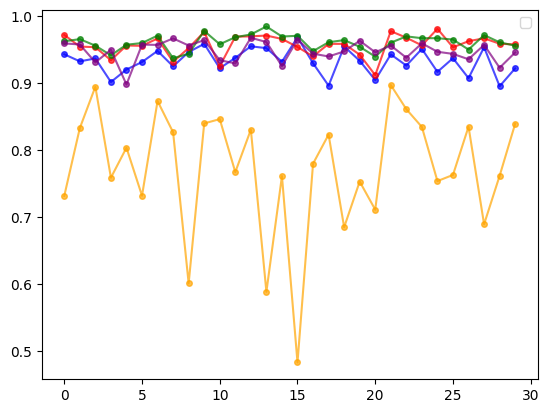

In [149]:
plt.plot(r2_median_lst, 'o-', color='blue', alpha=0.7, markersize=4)
plt.plot(r2_q05_lst, 'o-', color='red', alpha=0.7, markersize=4)
plt.plot(r2_q25_lst, 'o-', color='green', alpha=0.7, markersize=4)
plt.plot(r2_q75_lst, 'o-', color='purple', alpha=0.7, markersize=4)
plt.plot(r2_q95_lst, 'o-', color='orange', alpha=0.7, markersize=4)
plt.legend()
plt.savefig("r2_propagation_r2_70_30.png", dpi=150)
plt.show()

/var/folders/ng/1zd7d3bs0p79qr4lw85bcbxh0000gn/T/ipykernel_63191/3494364039.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


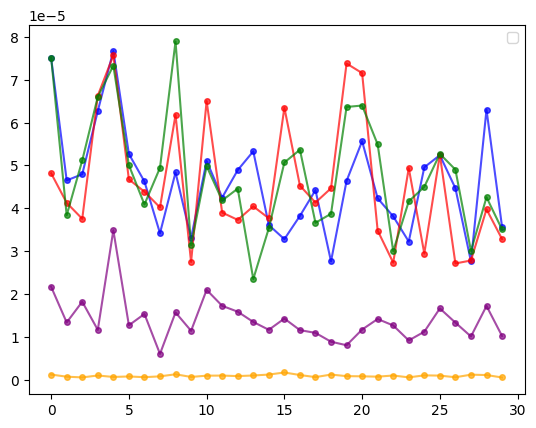

In [150]:
plt.plot(mse_median_lst, 'o-', color='blue', alpha=0.7, markersize=4)
plt.plot(mse_q05_lst, 'o-', color='red', alpha=0.7, markersize=4)
plt.plot(mse_q25_lst, 'o-', color='green', alpha=0.7, markersize=4)
plt.plot(mse_q75_lst, 'o-', color='purple', alpha=0.7, markersize=4)
plt.plot(mse_q95_lst, 'o-', color='orange', alpha=0.7, markersize=4)
plt.legend()
plt.savefig("mse_propagation_r2_70_30.png", dpi=150)
plt.show()